In [454]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine

In [455]:
books = pd.read_csv('BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines = False, encoding='latin-1')
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Publisher', 'Year-Of-Publication'], axis=1, inplace=True)
ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines = False, encoding='latin-1')
users = pd.read_csv('BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines = False, encoding='latin-1')
users.drop(['Location'], axis = 1, inplace=True)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/IPython/core/inte

Clean up data; do we have ratings for books that are not in the book data? Which rating system will we use (implict, explict)? Are there Nans?

In [456]:
ratings_allbooks = ratings[ratings['ISBN'].isin(books['ISBN'])]

In [457]:
ratings_implicit = ratings_allbooks[ratings_allbooks["Book-Rating"] == 0]
ratings_explicit = ratings_allbooks[ratings_allbooks["Book-Rating"] != 0]
print("Implict: {}".format(len(ratings_implicit)))
print("Explicit: {}".format(len(ratings_explicit)))

Implict: 647294
Explicit: 383842


In [458]:
users = users.where(pd.notnull(users), np.nanmedian(users['Age']))
#serpate users by users who have given implicit/explicit ratings
users_exp_ratings = users[users['User-ID'].isin(ratings_explicit['User-ID'])]
users_imp_ratings = users[users['User-ID'].isin(ratings_implicit['User-ID'])]

In [459]:
ratings_implicit["Book-Rating"] = np.ones(len(ratings_implicit['Book-Rating']))

/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Populatarity based recommendations; what books have been read the most? 

In [460]:
ratings_pop = pd.DataFrame(ratings_implicit.groupby(['ISBN'])['Book-Rating'].sum())
top10 = ratings_pop.sort_values('Book-Rating', ascending=False).head(10)
top10.merge(books, left_index=True, right_on = 'ISBN')

,Book-Rating,ISBN,Book-Title,Book-Author
26,1921.0,0971880107,Wild Animus,Rich Shapero
408,588.0,0316666343,The Lovely Bones: A Novel,Alice Sebold
1105,412.0,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
748,396.0,0385504209,The Da Vinci Code,Dan Brown
305,366.0,044023722X,A Painted House,John Grisham
1922,358.0,067976402X,Snow Falling on Cedars,David Guterson
2445,349.0,0440214041,The Pelican Brief,John Grisham
522,340.0,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant
67,325.0,0804106304,The Joy Luck Club,Amy Tan
4430,323.0,0375727345,House of Sand and Fog,Andre Dubus III


Make the dataset smaller, we don't need users that have rated few books or books with few ratings

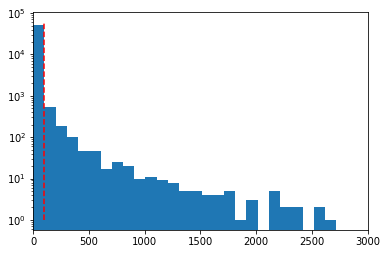

In [461]:
count_users = ratings_implicit['User-ID'].value_counts()
plt.hist(count_users.values, bins = int(np.max(count_users.values)/100))
plt.yscale('log')
plt.xlim(0, 3000)
plt.plot([100, 100],[1, 60000], linestyle = 'dashed', color = 'red')

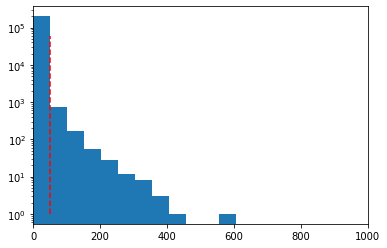

In [586]:
count_books= ratings_implicit['ISBN'].value_counts()
plt.hist(count_books.values, bins = int(np.max(count_books.values)/50))
plt.yscale('log')
plt.xlim(0, 1000)
plt.plot([50, 50],[1, 60000], linestyle = 'dashed', color = 'red')

Take only the books with more than 50 ratings and only the users who have rated at least 100 books

In [587]:
ratings_implicit = ratings_implicit[ratings_implicit['User-ID'].isin(count_users[count_users >=100].index)]
ratings_implicit = ratings_implicit[ratings_implicit['ISBN'].isin(count_books[count_books >=50].index)]

In [599]:
#create the ratings/users matrix
ratings_matrix = ratings_implicit.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
ratings_matrix = ratings_matrix.where(pd.notnull(ratings_matrix), 0)
#ratings_matrix.iloc[:,:] = sk.preprocessing.Normalizer(norm='l2').fit_transform(ratings_matrix)
print(ratings_matrix.shape)
ratings_matrix[:10]

(1071, 1073)


ISBN,002026478X,002542730X,0060008032,0060085444,0060096195,006016848X,0060173289,0060175400,006019491X,0060199652,...,1565122968,1573225517,1573225789,1573227331,1573229326,1573229571,1573229725,1576737330,1592400876,1878424319
User-ID,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3363,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [600]:
max(ratings_matrix.iloc[9, :])

1.0

In [601]:
knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

In [602]:
knn_model.fit(ratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [635]:
def findBooks(user_inds):
    books = np.zeros(ratings_matrix.iloc[0, :].values.shape)
    for ids in user_inds:
        user_vec = ratings_matrix.iloc[ids, :].values
        books = books + user_vec
    
    books = pd.Series(books)
    books = books.sort_values(ascending=False)
    top100 = books[:100]
    bookIds = []
    bookValues = []
    for i, ind in enumerate(top100.index):
        bookIds.append(ratings_matrix.columns[ind])
        bookValues.append(top100.values[i])
    return bookIds, bookValues

In [636]:
#find the mean rating for a given user, only looking at book which they've rated
def calcMean(user_loc):
    user_ratings = ratings_matrix.iloc[user_loc, :]
    #select only where rating != 0
    user_ratings = user_ratings[user_ratings != 0]
    
    mean = np.sum(user_ratings)/len(user_ratings)
    return mean

In [640]:
#predict rating for a specific item/user
def predict_rating_explicit(user_loc, item_loc, sim_user_ind, sims):
    mean_rating_user = calcMean(user_loc)
    sim_sum = np.sum(sims)
    rate_sum = 0
    #loop through similar users
    for i, sim_user in enumerate(sim_user_ind):        
        product = ratings_matrix.iloc[sim_user, item_loc]*sims[i]
        rate_sum=new_sum+product

    prediction = (rate_sum/sim_sum)
    return prediction

#predict rating for a specific item/user
def predict_rating_implicit(user_loc, item_loc, sim_user_ind, sims, bookvalue):
    mean_rating_user = calcMean(user_loc)
    sim_sum = np.sum(sims)
    rate_sum = 0
    #loop through similar users
    for i, sim_user in enumerate(sim_user_ind):        
        product= bookvalue*ratings_matrix.iloc[sim_user, item_loc]*sims[i]  #weight rating by similarity
        rate_sum=rate_sum+product

    prediction = (rate_sum)
    return prediction

In [649]:
#find the most likely to be read over all books
def recommendbook(user_id):
    user_loc = ratings_matrix.index.get_loc(user_id)
    user_vec = ratings_matrix.iloc[user_loc, :].values.reshape(1, -1)
    
    #find similar users
    dist, indices = knn_model.kneighbors(user_vec, n_neighbors= 10)
    print(dist.shape)
    
    #ignore the first item, it is the original user
    sims = 1-dist.flatten()[1:] #most similar is closest to 1
    sim_user_ind = indices.flatten()[1:]
    print(sims.shape)
    
    #list books similar users have read
    simUserBooks, bookValues = findBooks(sim_user_ind)
    print(bookValues)
    
    predictions = []
    for i, book in enumerate(simUserBooks):
        item_loc = ratings_matrix.columns.get_loc(book)
        if (ratings_matrix.iloc[user_loc, item_loc] == 0):
            #predictions.append((predict_rating_explicit(user_loc, item_loc, sim_user_ind, sims), book))
            predictions.append((predict_rating_implicit(user_loc, item_loc, sim_user_ind, sims, bookValues[i]), book))
        else:
            predictions.append((-1, book)) #already read
    
    predictions = pd.Series(predictions)
    predictions = predictions.sort_values(ascending=False)
    recommend = predictions[:10]

    for i, (rate, book) in enumerate(recommend):
        p = books.set_index('ISBN').index.get_loc(book)
        print("{} {} (expected rating {:0.2f})".format(i+1, books['Book-Title'][p], rate))

In [650]:
recommendbook(11676)

(1, 10)
(9,)
[8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
1 Where the Heart Is (Oprah's Book Club (Paperback)) (expected rating 19.50)
2 The Alienist (expected rating 19.34)
3 The Runaway Jury (expected rating 15.20)
4 The Testament (expected rating 15.15)
5 The Notebook (expected rating 15.14)
6 Hannibal (expected rating 15.10)
7 Before I Say Good-Bye (expected rating 15.08)
8 Midwives: A Novel (expected rating 14.95)
9 The Summerhouse (expected rating 14.77)
10 Winter Moon (expected rating 14.60)
